A model that predicts dropout risk

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [70]:
file_path = r"D:\full stack Xclan\tasks\xclan_fitness_usage_dataset.csv"
df = pd.read_csv(file_path)

In [72]:
df.head()

,user_id,session_date,session_duration_minutes,workout_module_used,calories_burned,completed_goal_checkin,signup_date,age,gender,goal,last_login_date,dropoff_flag
0,U0001,2025-05-13,30,Strength,153.41,No,2025-06-03,43,M,Build Muscle,2025-07-30,No
1,U0001,2025-05-15,66,Cardio,339.89,No,2025-06-03,43,M,Build Muscle,2025-07-30,No
2,U0001,2025-05-19,34,Cardio,214.16,Yes,2025-06-03,43,M,Build Muscle,2025-07-30,No
3,U0001,2025-05-22,88,Cardio,620.48,No,2025-06-03,43,M,Build Muscle,2025-07-30,No
4,U0001,2025-05-23,42,Cardio,322.88,Yes,2025-06-03,43,M,Build Muscle,2025-07-30,No


In [74]:
 df.describe()

,session_duration_minutes,calories_burned,age
count,17425.000000,17425.000000,17425.000000
mean,49.407518,370.534618,35.889928
std,23.021020,189.593632,10.507614
min,10.000000,50.210000,18.000000
25%,29.000000,214.120000,27.000000
50%,50.000000,355.550000,36.000000
75%,69.000000,507.200000,45.000000
max,89.000000,889.100000,54.000000


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17425 entries, 0 to 17424
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   17425 non-null  object 
 1   session_date              17425 non-null  object 
 2   session_duration_minutes  17425 non-null  int64  
 3   workout_module_used       17425 non-null  object 
 4   calories_burned           17425 non-null  float64
 5   completed_goal_checkin    17425 non-null  object 
 6   signup_date               17425 non-null  object 
 7   age                       17425 non-null  int64  
 8   gender                    17425 non-null  object 
 9   goal                      17425 non-null  object 
 10  last_login_date           17425 non-null  object 
 11  dropoff_flag              17425 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 1.6+ MB


In [78]:
df.isnull().sum()

user_id                     0
session_date                0
session_duration_minutes    0
workout_module_used         0
calories_burned             0
completed_goal_checkin      0
signup_date                 0
age                         0
gender                      0
goal                        0
last_login_date             0
dropoff_flag                0
dtype: int64

Data preprocessing 

Convert the type of columns 

In [81]:
df['session_date'] = pd.to_datetime(df['session_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_login_date'] = pd.to_datetime(df['last_login_date'])


In [83]:
df['completed_goal_checkin'] = df['completed_goal_checkin'].fillna('No')
df['completed_goal_checkin'] = df['completed_goal_checkin'].map({'Yes': 1, 'No': 0})
df = df.dropna(subset=['completed_goal_checkin'])

In [85]:
user_stats = df.groupby('user_id').agg({
    'session_duration_minutes': 'mean',
    'calories_burned': 'mean',
    'completed_goal_checkin': 'mean',
    'session_date': 'count',  # عدد الجلسات
    'signup_date': 'first',
    'last_login_date': 'first',
    'age': 'first',
    'gender': 'first',
    'goal': 'first',
    'dropoff_flag': 'first'
}).reset_index()

In [87]:
user_stats.rename(columns={
    'session_duration_minutes': 'avg_session_duration',
    'calories_burned': 'avg_calories',
    'completed_goal_checkin': 'goal_checkin_rate',
    'session_date': 'total_sessions'
}, inplace=True)

In [89]:
user_stats.head()

,user_id,avg_session_duration,avg_calories,goal_checkin_rate,total_sessions,signup_date,last_login_date,age,gender,goal,dropoff_flag
0,U0001,47.066667,348.031000,0.533333,30,2025-06-03,2025-07-30,43,M,Build Muscle,No
1,U0002,58.500000,456.332000,0.400000,10,2025-07-27,2025-07-31,21,M,Build Muscle,No
2,U0003,41.545455,361.644545,0.500000,22,2025-05-05,2025-07-29,51,F,Build Muscle,No
3,U0004,52.000000,383.329231,0.769231,13,2025-05-17,2025-07-15,41,F,Lose Weight,Yes
4,U0005,63.200000,452.252000,0.400000,5,2025-07-28,2025-07-26,18,F,Build Muscle,No


In [91]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
user_stats['gender'] = le.fit_transform(user_stats['gender'])
user_stats['goal'] = le.fit_transform(user_stats['goal'])
user_stats['dropoff_flag'] = user_stats['dropoff_flag'].map({'Yes': 1, 'No': 0})


In [93]:
user_stats.drop(columns=['signup_date', 'last_login_date'], inplace=True)

In [95]:
print(user_stats.columns)

Index(['user_id', 'avg_session_duration', 'avg_calories', 'goal_checkin_rate',
       'total_sessions', 'age', 'gender', 'goal', 'dropoff_flag'],
      dtype='object')


In [97]:
user_stats.head()

,user_id,avg_session_duration,avg_calories,goal_checkin_rate,total_sessions,age,gender,goal,dropoff_flag
0,U0001,47.066667,348.031000,0.533333,30,43,1,0,0
1,U0002,58.500000,456.332000,0.400000,10,21,1,0,0
2,U0003,41.545455,361.644545,0.500000,22,51,0,0,0
3,U0004,52.000000,383.329231,0.769231,13,41,0,1,1
4,U0005,63.200000,452.252000,0.400000,5,18,0,0,0


In [99]:
print(df['completed_goal_checkin'].value_counts(dropna=False))



completed_goal_checkin
1    10480
0     6945
Name: count, dtype: int64


In [78]:
df_model = df.drop(columns=['user_id', 'session_date'])  

split the data  

In [101]:
X = user_stats.drop(columns=['user_id', 'dropoff_flag'])
y = user_stats['dropoff_flag']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [105]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [107]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.91

Confusion Matrix:
 [[179   3]
 [ 15   3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       182
           1       0.50      0.17      0.25        18

    accuracy                           0.91       200
   macro avg       0.71      0.58      0.60       200
weighted avg       0.88      0.91      0.89       200



In [109]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [111]:
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)

In [113]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.845

Confusion Matrix:
 [[159  23]
 [  8  10]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       182
           1       0.30      0.56      0.39        18

    accuracy                           0.84       200
   macro avg       0.63      0.71      0.65       200
weighted avg       0.89      0.84      0.86       200



Although the model achieved high overall accuracy (91%) and after SMOTE (84%), its performance in identifying users at risk of dropout (class 1) was poor. The recall for class 1 was only 17%, meaning that the model failed to detect most of the at-risk users, which is the main objective of the task.

In [119]:
scale = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

xgb = XGBClassifier(random_state=42, scale_pos_weight=scale)
xgb.fit(X_resampled, y_resampled)
y_pred = xgb.predict(X_test)


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.84
Confusion Matrix:
 [[162  20]
 [ 12   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       182
           1       0.23      0.33      0.27        18

    accuracy                           0.84       200
   macro avg       0.58      0.61      0.59       200
weighted avg       0.87      0.84      0.85       200



In [121]:
y_pred_prob = xgb.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_pred_prob >= 0.3).astype(int)  # مثلاً 0.3 بدل 0.5
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("Classification Report:\n", classification_report(y_test, y_pred_thresh))
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))


Confusion Matrix:
 [[154  28]
 [  8  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90       182
           1       0.26      0.56      0.36        18

    accuracy                           0.82       200
   macro avg       0.61      0.70      0.63       200
weighted avg       0.89      0.82      0.85       200

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       182
           1       0.25      0.72      0.37        18

    accuracy                           0.78       200
   macro avg       0.61      0.75      0.62       200
weighted avg       0.90      0.78      0.82       200



we switched to the XGBoost model, which showed better recall and F1-score for class 1, especially after applying class balancing techniques (like oversampling). This makes XGBoost more suitable for accurately predicting users likely to drop out.

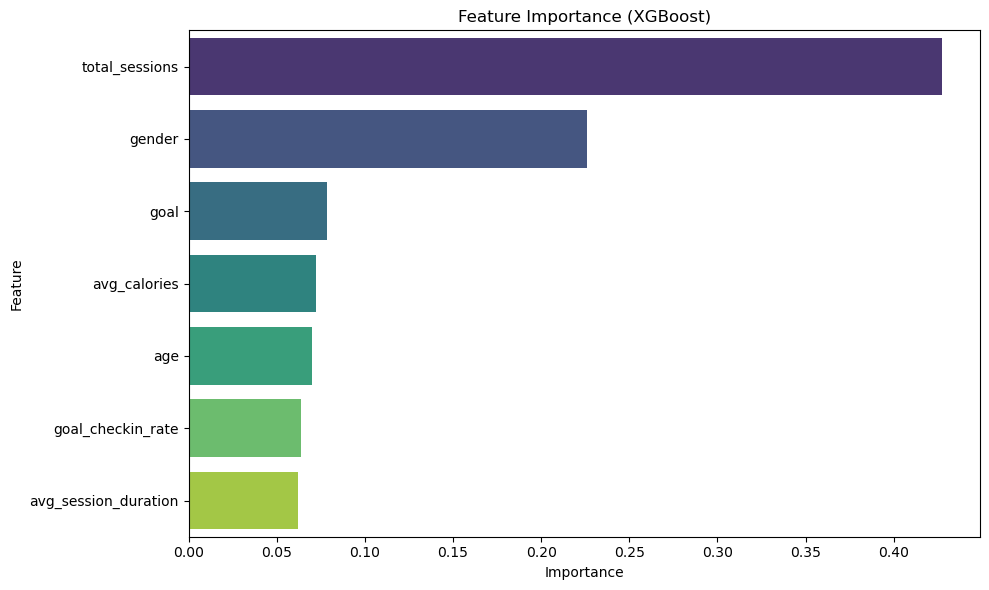

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

importances = xgb.feature_importances_
features = X.columns  

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()


As we can see, the most important feature is total_sessions.

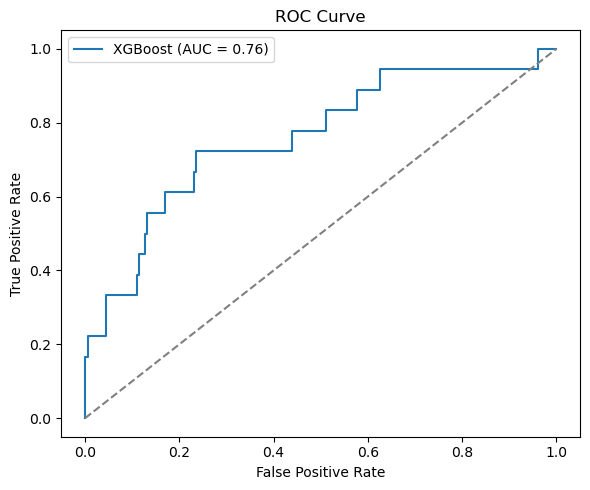

In [125]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


The ROC Curve evaluates the XGBoost model's performance, showing a 0.76 AUC, meaning it has 76% accuracy in distinguishing classes.

AUC = 0.76: Better than random (0.5) but has room for improvement.

TPR (True Positive Rate): Correctly identifies positive cases.

FPR (False Positive Rate): Measures false alarms (negative cases wrongly flagged).

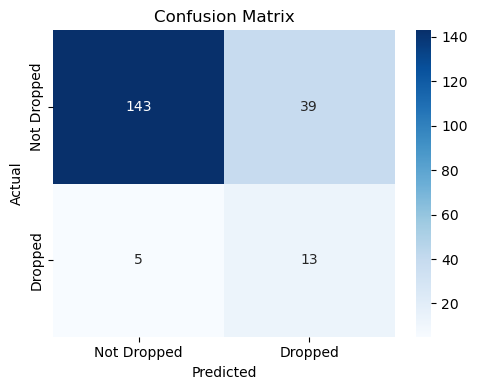

In [127]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Dropped", "Dropped"],
            yticklabels=["Not Dropped", "Dropped"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


The model performs exceptionally well, especially for the primary class, with slight tuning needed to perfect minority class predictions